## Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy.

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 

### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.naive_bayes import GaussianNB

from astroML.classification import GMMBayes

from astroML.utils import completeness_contamination

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=[6,5]

### Data

In [2]:
data=pd.read_csv('galaxyquasar.csv')

#let's have a look at the data
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
u_g = np.array(data['u']-data['g'])
g_r = np.array(data['g']-data['r'])
r_i = np.array(data['r']-data['i'])
i_z = np.array(data['i']-data['z'])

# 0=QSO 1=Galaxy

label=np.array(data['class'])
label=np.array(label=='GALAXY', dtype=int)

colors=['u-g', 'g-r', 'r-i', 'i-z']

In [4]:
#splitting the dataset

X=np.array([u_g,g_r,r_i,i_z]).T

X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.5, random_state=1)

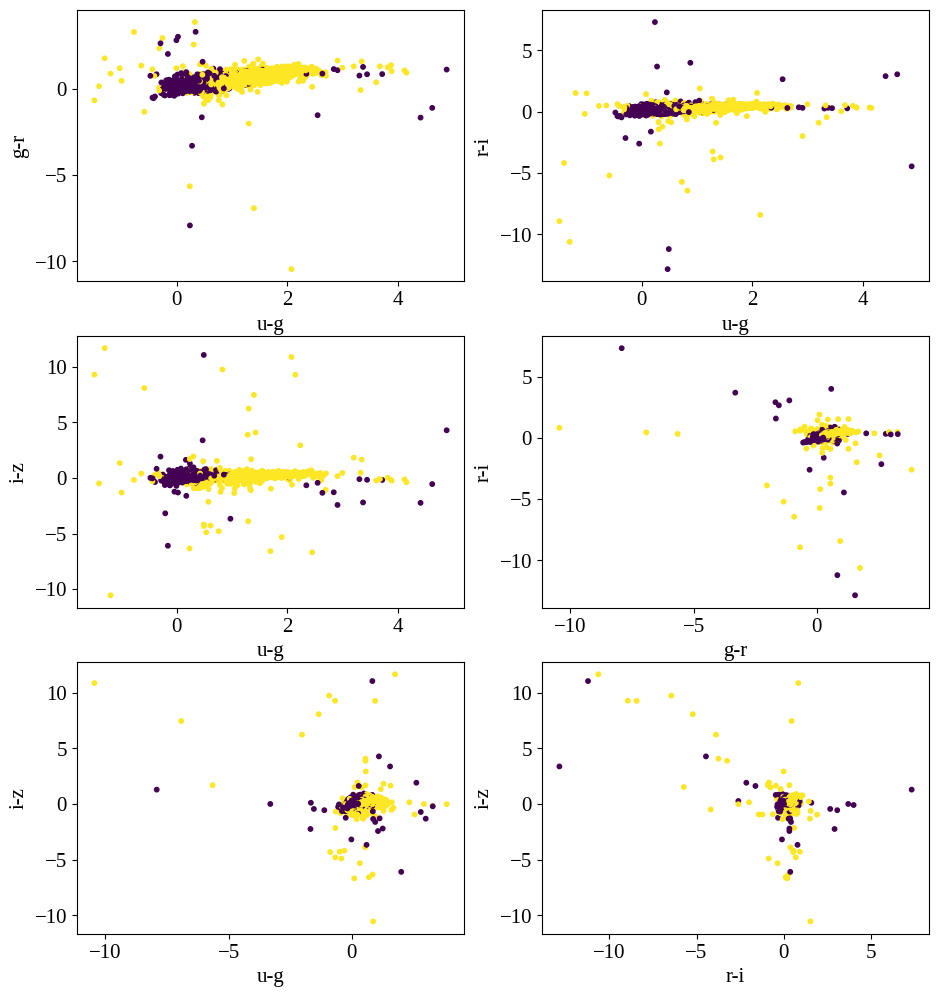

In [5]:
s=10

fig = plt.figure(figsize=(11, 12))

ax=fig.add_subplot(321)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=s)
plt.xlabel('u-g')
plt.ylabel('g-r')

ax=fig.add_subplot(322)
plt.scatter(X_train[:,0], X_train[:,2], c=y_train, s=s)
plt.xlabel('u-g')
plt.ylabel('r-i')

ax=fig.add_subplot(323)
plt.scatter(X_train[:,0], X_train[:,3], c=y_train, s=s)
plt.xlabel('u-g')
plt.ylabel('i-z')

ax=fig.add_subplot(324)
plt.scatter(X_train[:,1], X_train[:,2], c=y_train, s=s)
plt.xlabel('g-r')
plt.ylabel('r-i')

ax=fig.add_subplot(325)
plt.scatter(X_train[:,1], X_train[:,3], c=y_train, s=s)
plt.xlabel('u-g')
plt.ylabel('i-z')

ax=fig.add_subplot(326)
plt.scatter(X_train[:,2], X_train[:,3], c=y_train, s=s)
plt.xlabel('r-i')
plt.ylabel('i-z')

plt.show()

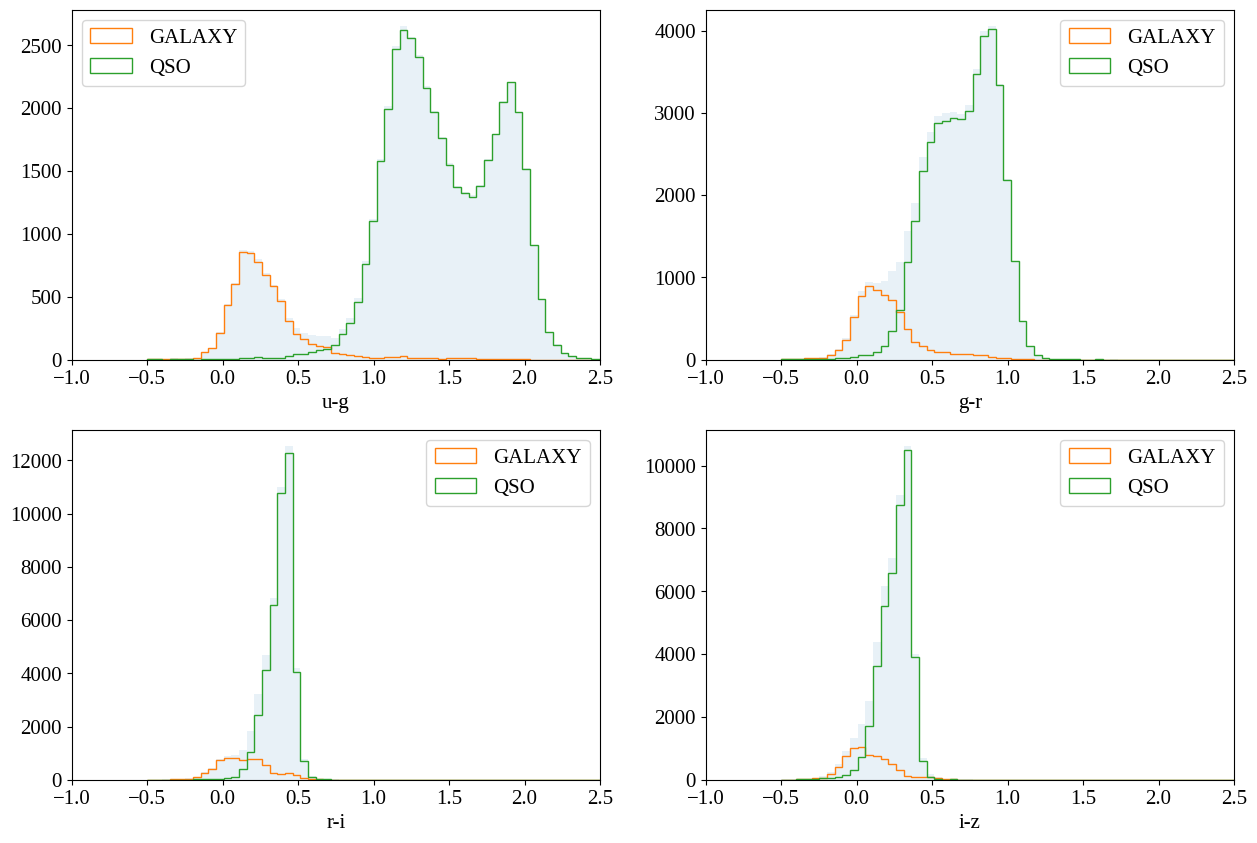

In [8]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-0.5, 3, 70)

for a,i in zip(axs, range(len(X))):
    a.hist(X[:,i], bins=bins, alpha=0.1)
    a.hist(X[:,i][label==0], bins=bins, histtype='step', lw=1, label='GALAXY')
    a.hist(X[:,i][label==1], bins=bins, histtype='step', lw=1, label='QSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-1,2.5)
    a.legend()

plt.show()

We can observe that there are some bands, in particular the $u-g$ and $g-r$ bands, in which the two groups are better separated. We can expect these features to be more important in the classification, rahter than the other two bands ($r-i$ and $i-z$), which show a clear overlap of the two distributions. But this, in peinciple, doesn't mean that these bands are useless. 

Let's start by considering all the 4 bands and perform some classifications alghoritms. In particular I considered:
* `Gaussian Naive Bayes`
* `GMM Bayes`
* `K-Nearest Neighbors`
* `Random forest`
* `Boosting`

In [6]:
def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)
                   / len(y))

def errors_cv(X, y, clf):
    cverr = []
    trainerr = []
    
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train, y_cv = y[train_index], y[cv_index]
        
        clf.fit(X_train, y_train)
        trainerr.append(rms_error(X_train, y_train, clf))
        cverr.append(rms_error(X_cv, y_cv, clf))
        #print(trainerr, cverr)
    
    return np.median(cverr), np.median(trainerr)

In [7]:
def compare_plot(clf):
    
    s=10
    
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    
    fig = plt.figure(figsize=(12,12))

    ax=fig.add_subplot(221)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=s)
    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.title('True label, training set')

    ax=fig.add_subplot(222)
    plt.scatter(X_train[:,0], X_train[:,1], c=train_pred, s=s)
    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.title('Predicted label, training set')

    ax=fig.add_subplot(223)
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=s)
    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.title('True label, test set')


    ax=fig.add_subplot(224)
    plt.scatter(X_test[:,0], X_test[:,1], c=test_pred, s=s)
    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.title('Predicted label, test set')


    plt.show()

### Gaussian Naive Bayes

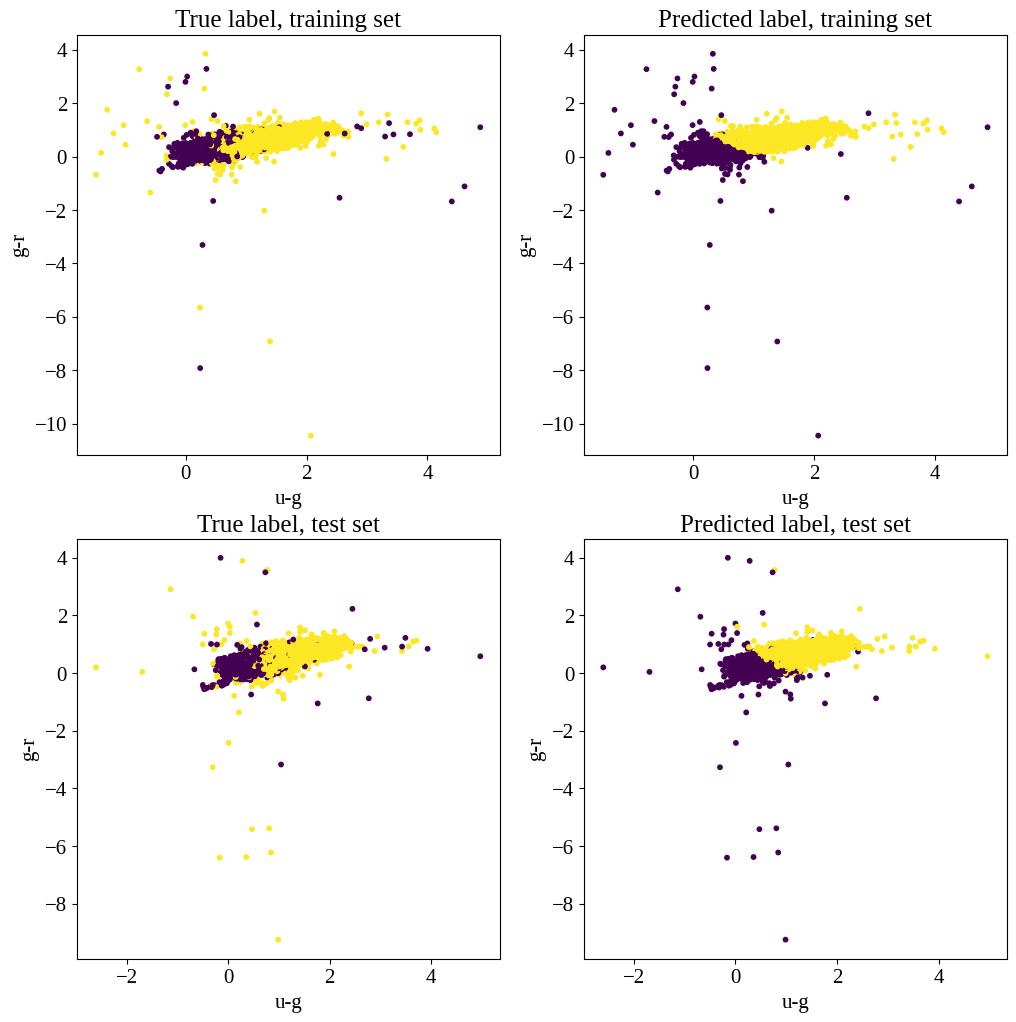

In [11]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

train_pred_gnb = gnb.predict(X_train)
test_pred_gnb = gnb.predict(X_test)

compare_plot(gnb)

In [12]:
accuracy_train_gnb = accuracy_score(y_train, train_pred_gnb)
accuracy_test_gnb = accuracy_score(y_test, test_pred_gnb)

print('The accuracy of the training set is:', accuracy_train_gnb)
print('The accuracy of the test set is:', accuracy_test_gnb)

cm_train_gnb = confusion_matrix(y_train, train_pred_gnb)
cm_test_gnb = confusion_matrix(y_test, test_pred_gnb)

print('\n Confusion matrix of the training set: \n',  cm_train_gnb)
print('\n Confusion matrix of the test set: \n',  cm_test_gnb)

completeness_gnb, contamination_gnb = completeness_contamination(test_pred_gnb, y_test)

print("\ncompleteness", round(float(completeness_gnb),3))
print("contamination", round(float(contamination_gnb),3))

The accuracy of the training set is: 0.97272
The accuracy of the test set is: 0.97388

 Confusion matrix of the training set: 
 [[ 3260   303]
 [  379 21058]]

 Confusion matrix of the test set: 
 [[ 3308   263]
 [  390 21039]]

completeness 0.982
contamination 0.012


### GMM Bayes

In [13]:
#try other algorithms

kf = KFold(n_splits=5, shuffle=True, random_state=8)

ncom = np.linspace(1, 20, 20, dtype=int)
cverr_GMM =[]
trainerr_GMM = []

for n in ncom:
    gmmb = GMMBayes(n, random_state=8)
    cverr, trainerr = errors_cv(X_train, y_train, gmmb)
    cverr_GMM.append(cverr)
    trainerr_GMM.append(trainerr)
    
ncom_best = ncom[cverr_GMM == min(cverr_GMM)][0]
print('best number of components:',ncom_best)

best number of components: 19


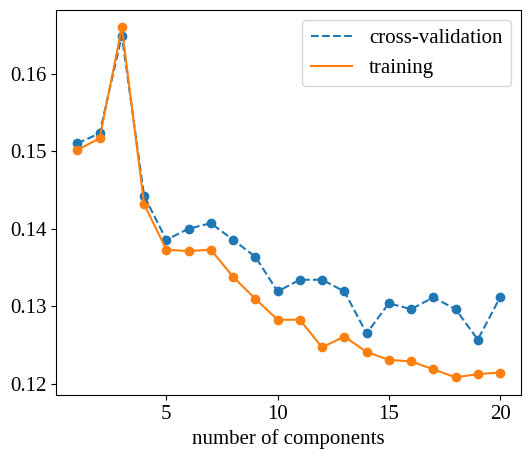

In [14]:
plt.scatter(ncom, cverr_GMM)
plt.scatter(ncom, trainerr_GMM)
plt.plot(ncom, cverr_GMM, '--', label='cross-validation')
plt.plot(ncom, trainerr_GMM, '-', label='training')
plt.legend()
plt.xlabel('number of components')
plt.show()

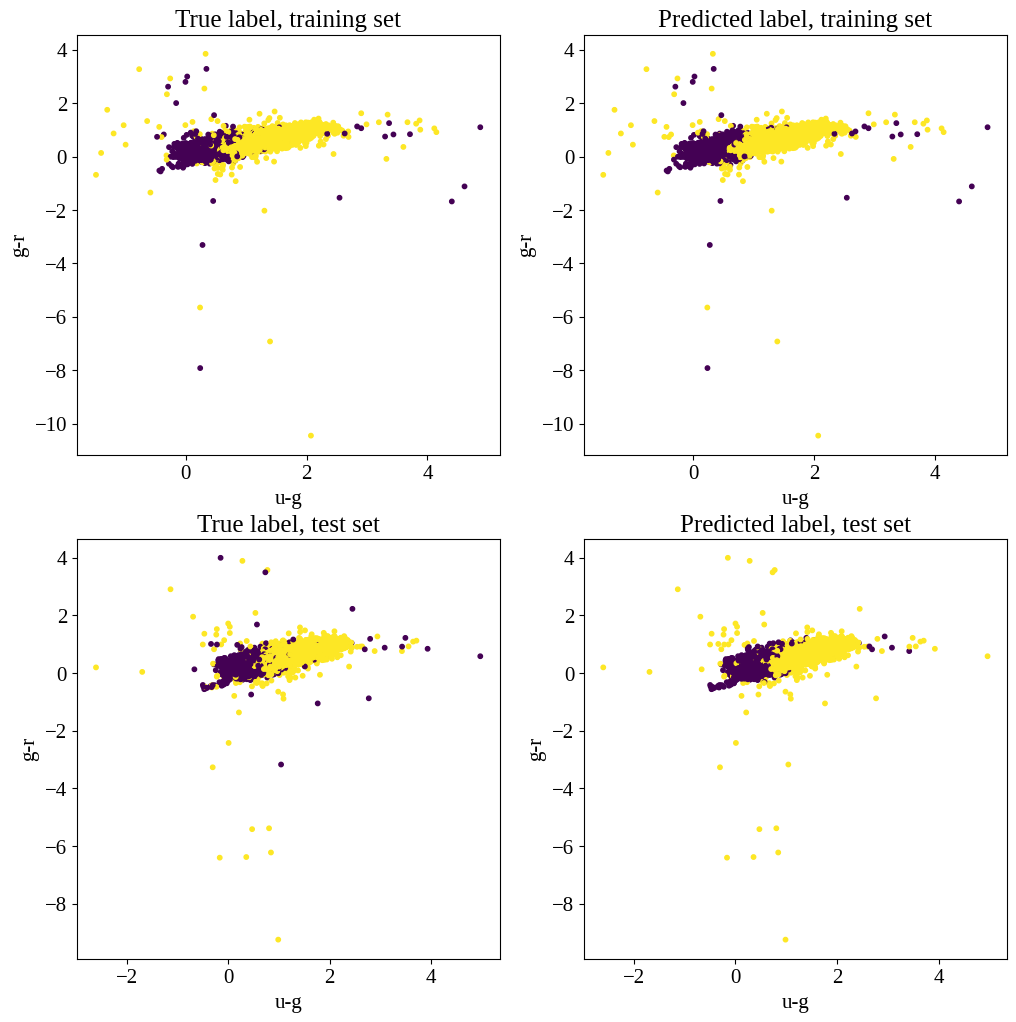

In [15]:
gmm = GMMBayes(ncom_best, random_state=5)
gmm.fit(X_train,y_train)

train_pred_gmm = gmm.predict(X_train)
test_pred_gmm= gmm.predict(X_test)

compare_plot(gmm)

In [16]:
accuracy_train_gmm = accuracy_score(y_train, train_pred_gmm)
accuracy_test_gmm = accuracy_score(y_test, test_pred_gmm)

print('The accuracy of the training set is:', accuracy_train_gmm)
print('The accuracy of the test set is:', accuracy_test_gmm)

cm_train_gmm = confusion_matrix(y_train, train_pred_gmm)
cm_test_gmm = confusion_matrix(y_test, test_pred_gmm)

print('\n Confusion matrix of the training set: \n',  cm_train_gmm)
print('\n Confusion matrix of the test set: \n',  cm_test_gmm)

completeness_gmm, contamination_gmm = completeness_contamination(test_pred_gmm, y_test)

print("\ncompleteness", round(float(completeness_gmm),3))
print("contamination", round(float(contamination_gmm),3))

The accuracy of the training set is: 0.9854
The accuracy of the test set is: 0.98604

 Confusion matrix of the training set: 
 [[ 3349   214]
 [  151 21286]]

 Confusion matrix of the test set: 
 [[ 3383   188]
 [  161 21268]]

completeness 0.992
contamination 0.009


### K-Nearest Neighbors

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)

nn = np.linspace(1, 20, 20, dtype=int)
cverr_KNN =[]
trainerr_KNN = []

for n in nn:
    knn = KNeighborsClassifier(n_neighbors=n)
    cverr, trainerr = errors_cv(X_train, y_train, knn)
    cverr_KNN.append(cverr)
    trainerr_KNN.append(trainerr)
    
nn_best = nn[cverr_KNN == min(cverr_KNN)][0]
print('best number of components:',nn_best)

best number of components: 7


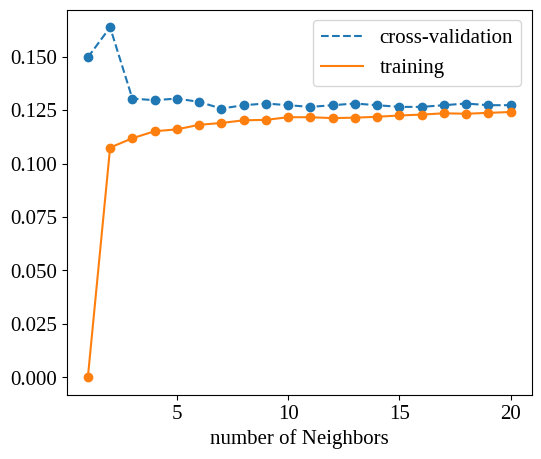

In [18]:
plt.scatter(nn, cverr_KNN)
plt.scatter(nn, trainerr_KNN)
plt.plot(nn, cverr_KNN, '--', label='cross-validation')
plt.plot(nn, trainerr_KNN, '-', label='training')
plt.legend()
plt.xlabel('number of Neighbors')
plt.show()

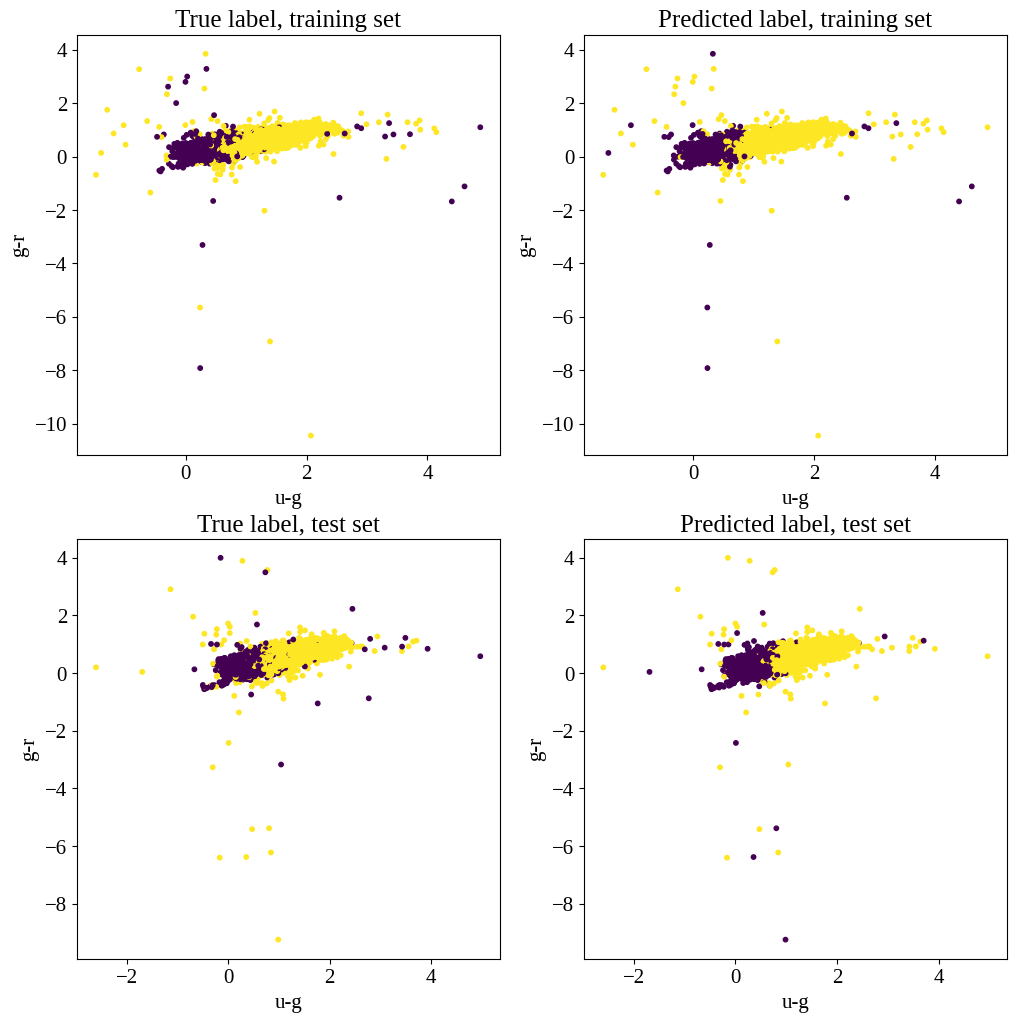

In [19]:
knc = KNeighborsClassifier(n_neighbors=nn_best)

knc.fit(X_train,y_train)

train_pred_knc = knc.predict(X_train)
test_pred_knc = knc.predict(X_test)

compare_plot(knc)

In [20]:
accuracy_train_knc = accuracy_score(y_train, train_pred_knc)
accuracy_test_knc = accuracy_score(y_test, test_pred_knc)

print('The accuracy of the training set is:', accuracy_train_knc)
print('The accuracy of the test set is:', accuracy_test_knc)

cm_train_knc = confusion_matrix(y_train, train_pred_knc)
cm_test_knc = confusion_matrix(y_test, test_pred_knc)

print('\n Confusion matrix of the training set: \n',  cm_train_knc)
print('\n Confusion matrix of the test set: \n',  cm_test_knc)

completeness_knc, contamination_knc = completeness_contamination(test_pred_knc, y_test)

print("\ncompleteness", round(float(completeness_knc),3))
print("contamination", round(float(contamination_knc),3))

The accuracy of the training set is: 0.98604
The accuracy of the test set is: 0.98664

 Confusion matrix of the training set: 
 [[ 3343   220]
 [  129 21308]]

 Confusion matrix of the test set: 
 [[ 3385   186]
 [  148 21281]]

completeness 0.993
contamination 0.009


### Random forest

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)

nt = np.linspace(5, 25, 20, dtype=int)
cverr_RF =[]
trainerr_RF = []

for n in nt:
    ranfor = RandomForestClassifier(n)
    cverr, trainerr = errors_cv(X_train, y_train, ranfor)
    cverr_RF.append(cverr)
    trainerr_RF.append(trainerr)
    
nt_best = nt[cverr_RF == min(cverr_RF)][0]
print('best number of components:',nt_best)

best number of components: 17


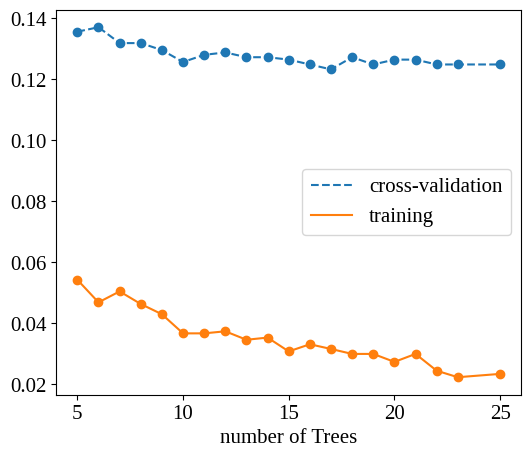

In [13]:
plt.scatter(nt, cverr_RF)
plt.scatter(nt, trainerr_RF)
plt.plot(nt, cverr_RF, '--', label='cross-validation')
plt.plot(nt, trainerr_RF, '-', label='training')
plt.legend()
plt.xlabel('number of Trees')
plt.show()

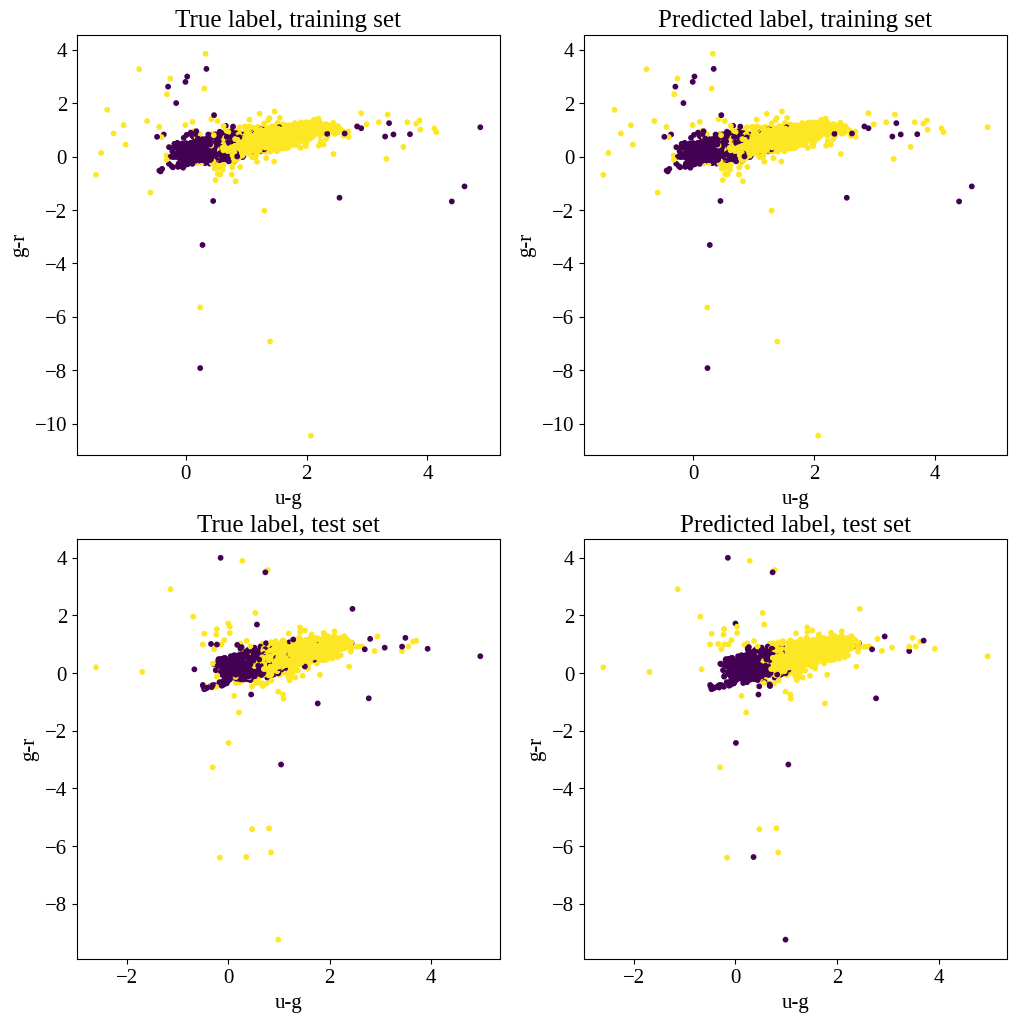

In [23]:
ranfor = RandomForestClassifier(nt_best)

ranfor.fit(X_train,y_train)

train_pred_rf = ranfor.predict(X_train)
test_pred_rf = ranfor.predict(X_test)

compare_plot(ranfor)

In [24]:
accuracy_train_rf = accuracy_score(y_train, train_pred_rf)
accuracy_test_rf = accuracy_score(y_test, test_pred_rf)

print('The accuracy of the training set is:', accuracy_train_rf)
print('The accuracy of the test set is:', accuracy_test_rf)

cm_train_rf = confusion_matrix(y_train, train_pred_rf)
cm_test_rf = confusion_matrix(y_test, test_pred_rf)

print('\n Confusion matrix of the training set: \n',  cm_train_rf)
print('\n Confusion matrix of the test set: \n',  cm_test_rf)

completeness_rf, contamination_rf = completeness_contamination(test_pred_rf, y_test)

print("\ncompleteness", round(float(completeness_rf),3))
print("contamination", round(float(contamination_rf),3))

The accuracy of the training set is: 0.99912
The accuracy of the test set is: 0.98672

 Confusion matrix of the training set: 
 [[ 3544    19]
 [    3 21434]]

 Confusion matrix of the test set: 
 [[ 3393   178]
 [  154 21275]]

completeness 0.993
contamination 0.008


### Boosting

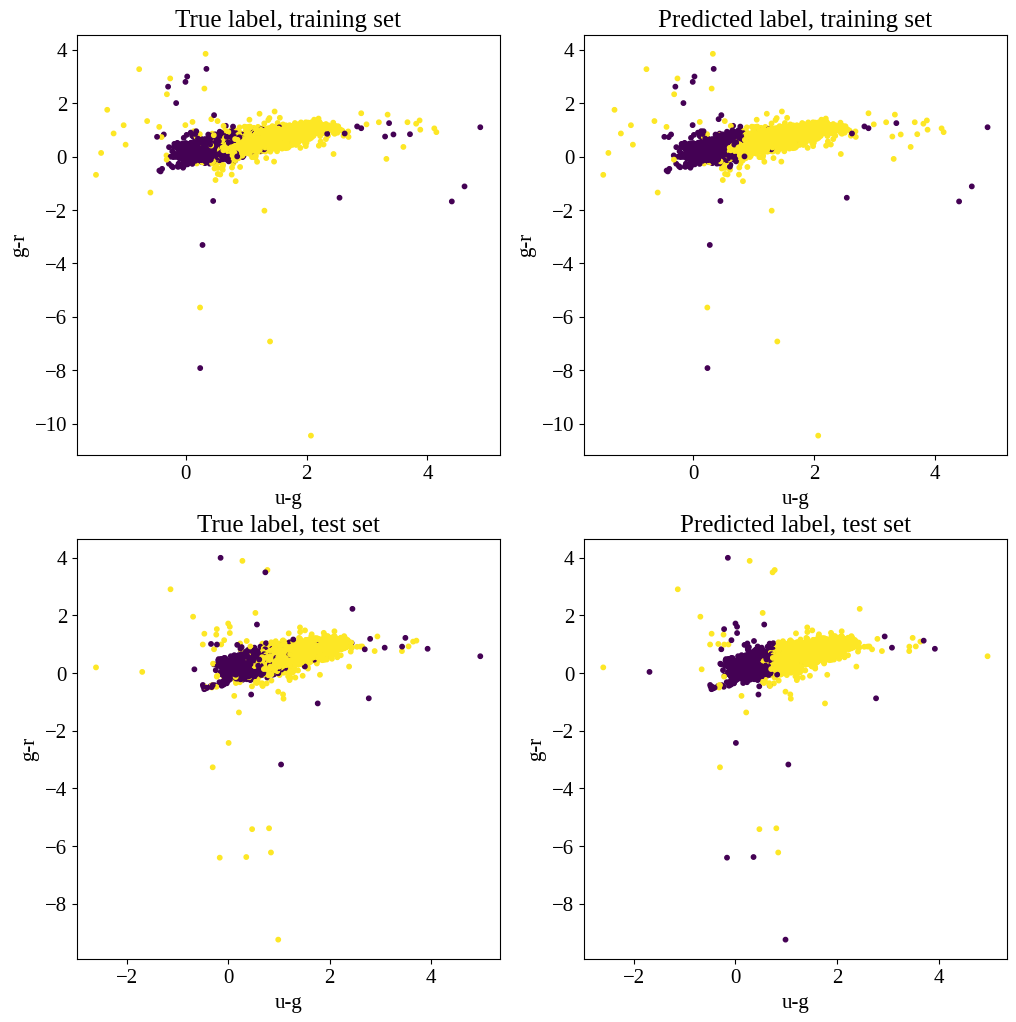

In [25]:
gradboost = GradientBoostingClassifier()

gradboost.fit(X_train,y_train)

train_pred_gb = gradboost.predict(X_train)
test_pred_gb = gradboost.predict(X_test)

compare_plot(gradboost)

In [26]:
accuracy_train_gb = accuracy_score(y_train, train_pred_gb)
accuracy_test_gb = accuracy_score(y_test, test_pred_gb)

print('The accuracy of the training set is:', accuracy_train_gb)
print('The accuracy of the test set is:', accuracy_test_gb)

cm_train_gb = confusion_matrix(y_train, train_pred_gb)
cm_test_gb = confusion_matrix(y_test, test_pred_gb)

print('\n Confusion matrix of the training set: \n',  cm_train_gb)
print('\n Confusion matrix of the test set: \n',  cm_test_gb)

completeness_gb, contamination_gb = completeness_contamination(test_pred_gb, y_test)

print("\ncompleteness", round(float(completeness_gb),3))
print("contamination", round(float(contamination_gb),3))

The accuracy of the training set is: 0.9872
The accuracy of the test set is: 0.98568

 Confusion matrix of the training set: 
 [[ 3361   202]
 [  118 21319]]

 Confusion matrix of the test set: 
 [[ 3374   197]
 [  161 21268]]

completeness 0.992
contamination 0.009


### Comparison

Let's now compare the results that we found.

In [27]:
#comparison

from tabulate import tabulate

classifier=np.array(["Gaussian Naive Bayes", "GMMBayes", "KNN", "Random forest", "Boosting"])
accuracy_train=np.array([accuracy_train_gnb, accuracy_train_gmm, accuracy_train_knc, accuracy_train_rf, 
                         accuracy_train_gb])
accuracy_test=np.array([accuracy_test_gnb, accuracy_test_gmm, accuracy_test_knc, accuracy_test_rf,
                         accuracy_test_gb])
completeness=np.array([completeness_gnb, completeness_gmm, completeness_knc, completeness_rf, 
                         completeness_gb])
contamination=np.array([contamination_gnb, contamination_gmm, contamination_knc, contamination_rf, 
                         contamination_gb])

results = np.array([classifier, accuracy_train, accuracy_test, completeness, contamination]).T

col_names=["classifier", "accuracy train", "accuracy test", "completeness", "contamination"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

╒══════════════════════╤══════════════════╤═════════════════╤════════════════╤═════════════════╕
│ classifier           │   accuracy train │   accuracy test │   completeness │   contamination │
╞══════════════════════╪══════════════════╪═════════════════╪════════════════╪═════════════════╡
│ Gaussian Naive Bayes │          0.97272 │         0.97388 │       0.9818   │      0.0123463  │
├──────────────────────┼──────────────────┼─────────────────┼────────────────┼─────────────────┤
│ GMMBayes             │          0.9854  │         0.98604 │       0.992487 │      0.00876212 │
├──────────────────────┼──────────────────┼─────────────────┼────────────────┼─────────────────┤
│ KNN                  │          0.98604 │         0.98664 │       0.993093 │      0.00866446 │
├──────────────────────┼──────────────────┼─────────────────┼────────────────┼─────────────────┤
│ Random forest        │          0.99912 │         0.98672 │       0.992813 │      0.00829721 │
├──────────────────────┼──────

With a direct approach to the data (without any manipulation) we got really accurate results. The different methods, with the exception of Gaussian Naive Bayes which performs slightly worse than the others, classify the data with an incredible accuracy. These methods guarantee completeness higher than $99\%$ with a contamination smaller than $1\%$.

Let's compute the **ROC curve** for the different classifier.

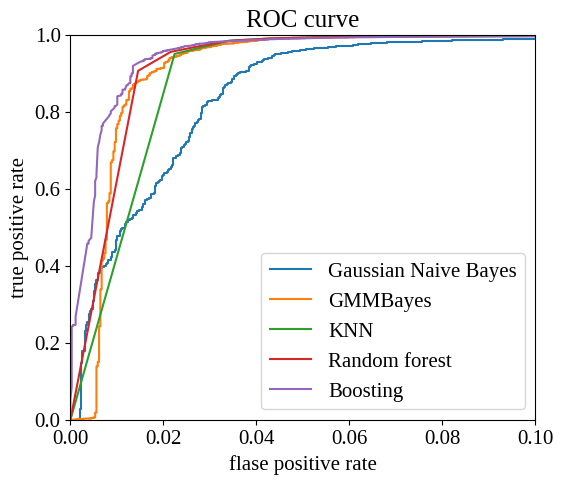

In [28]:
# Gaussian Naive Bayes
y_prob1 = gnb.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_prob1)


# GMMBayes
y_prob2= gmm.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob2)


# KNN 
y_prob3= knc.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_prob3)


# Random forest
y_prob4= ranfor.predict_proba(X_test)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_prob4)


# Boosting
y_prob5= gradboost.predict_proba(X_test)[:,1]
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_prob5)


plt.plot(fpr1, tpr1, label='Gaussian Naive Bayes')
plt.plot(fpr2, tpr2, label='GMMBayes')
plt.plot(fpr3, tpr3, label='KNN')
plt.plot(fpr4, tpr4, label='Random forest')
plt.plot(fpr5, tpr5, label='Boosting')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.1)
plt.ylim(0.,1)
plt.legend()
plt.show()

As we expect we can observe that the Gaussian Naive Bayes performs slightly worse than the other classifier, while the Boosting methods seems to be the better one.

Let's consider now the performance of the classifier as a function of the **number of features**.

In [29]:
#observe the completeness and contamination as a function of the number of features

def comp_cont_Features(X, y, clf):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
    completeness = np.zeros(4)
    contamination = np.zeros(4)
    
    for i in range(4):
        clf.fit(X_train[:,0:i+1] ,y_train)
        y_prob = clf.predict(X_test[:,0:i+1]) 
        completeness[i], contamination[i] = completeness_contamination(y_prob,y_test)
    return completeness, contamination;

In [30]:
comp1,cont1 = comp_cont_Features(X, label, GaussianNB())
comp2,cont2 = comp_cont_Features(X, label, GMMBayes(n_components=ncom_best, random_state=5))
comp3,cont3 = comp_cont_Features(X, label, KNeighborsClassifier(n_neighbors=nn_best))
comp4,cont4 = comp_cont_Features(X, label, RandomForestClassifier(nt_best))
comp5,cont5 = comp_cont_Features(X, label, GradientBoostingClassifier())

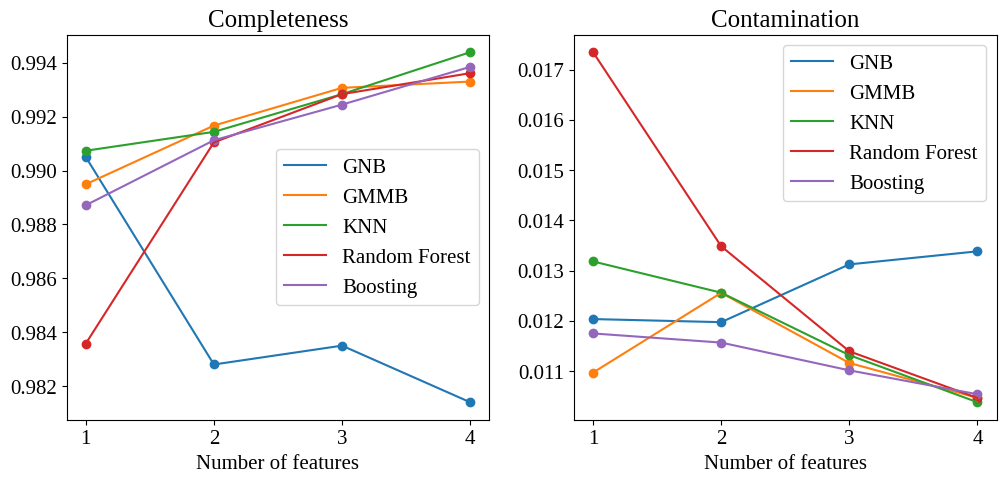

In [31]:
fig = plt.figure(figsize=(12,5))

# Completeness
ax1 = fig.add_subplot(121)  
ax1.scatter(np.arange(1,5),comp1)
ax1.scatter(np.arange(1,5),comp2)
ax1.scatter(np.arange(1,5),comp3)
ax1.scatter(np.arange(1,5),comp4)
ax1.scatter(np.arange(1,5),comp5)
ax1.plot(np.arange(1,5),comp1, label='GNB')
ax1.plot(np.arange(1,5),comp2, label='GMMB')
ax1.plot(np.arange(1,5),comp3, label='KNN')
ax1.plot(np.arange(1,5),comp4, label='Random Forest')
ax1.plot(np.arange(1,5),comp5, label='Boosting')
ax1.set_xlabel('Number of features')
ax1.set_title('Completeness')
ax1.legend()

# Contamination
ax2 = fig.add_subplot(122)
ax2.scatter(np.arange(1,5),cont1)
ax2.scatter(np.arange(1,5),cont2)
ax2.scatter(np.arange(1,5),cont3)
ax2.scatter(np.arange(1,5),cont4)
ax2.scatter(np.arange(1,5),cont5)
ax2.plot(np.arange(1,5),cont1, label='GNB')
ax2.plot(np.arange(1,5),cont2, label='GMMB')
ax2.plot(np.arange(1,5),cont3, label='KNN')
ax2.plot(np.arange(1,5),cont4, label='Random Forest')
ax2.plot(np.arange(1,5),cont5, label='Boosting')
ax2.set_xlabel('Number of features')
ax2.set_title('Contamination')
ax2.legend()

plt.show()

In general we obtain better results by increasing the number of features, with the exception of the Gaussian Naive Bayes, which presents the opposite trend. In particular if we consider only one dimension, the *GNB* performs better than the majority of the classifier that we considered. The other 4 algorithms instead provide better results considering all the 4 dimensions of the dataset, with the completeness and the contamination that seem to converge to a similar value for all the classifiers.

### Dimensionality reduction

Try to apply some dimensionality reduction algorithm to the data. Let's start by performing a **PCA** analysis, then apply the GMMBayes classification.

In [32]:
pca = PCA(n_components = 2)
X_reduced = pca.fit_transform(X)

print(X_reduced.shape)

(50000, 2)


In [33]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, label, test_size=0.5, random_state=1)

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=8)

ncom = np.linspace(1, 20, 20, dtype=int)
cverr_GMM = []
trainerr_GMM = []

for n in ncom:
    gmmb = GMMBayes(n, random_state=8)
    cverr, trainerr = errors_cv(X_train_r, y_train_r, gmmb)
    cverr_GMM.append(cverr)
    trainerr_GMM.append(trainerr)
    
ncom_best_r = ncom[cverr_GMM == min(cverr_GMM)][0]
print('best number of components:',ncom_best_r)

best number of components: 15


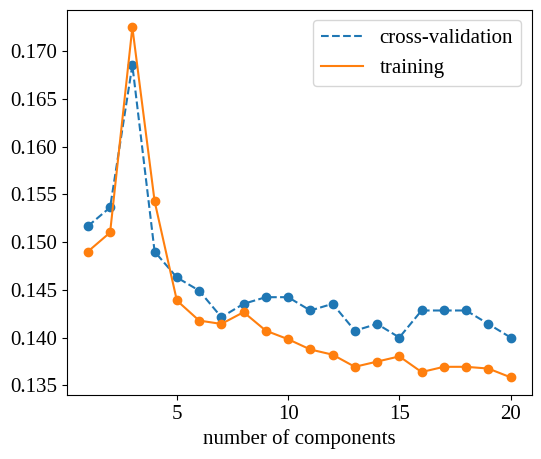

In [35]:
plt.scatter(ncom, cverr_GMM)
plt.scatter(ncom, trainerr_GMM)
plt.plot(ncom, cverr_GMM, '--', label='cross-validation')
plt.plot(ncom, trainerr_GMM, '-', label='training')
plt.legend()
plt.xlabel('number of components')
plt.show()

In [36]:
gmm_r = GMMBayes(ncom_best_r)
gmm_r.fit(X_train_r,y_train_r)

train_pred_gmm_r = gmm_r.predict(X_train_r)
test_pred_gmm_r = gmm_r.predict(X_test_r)

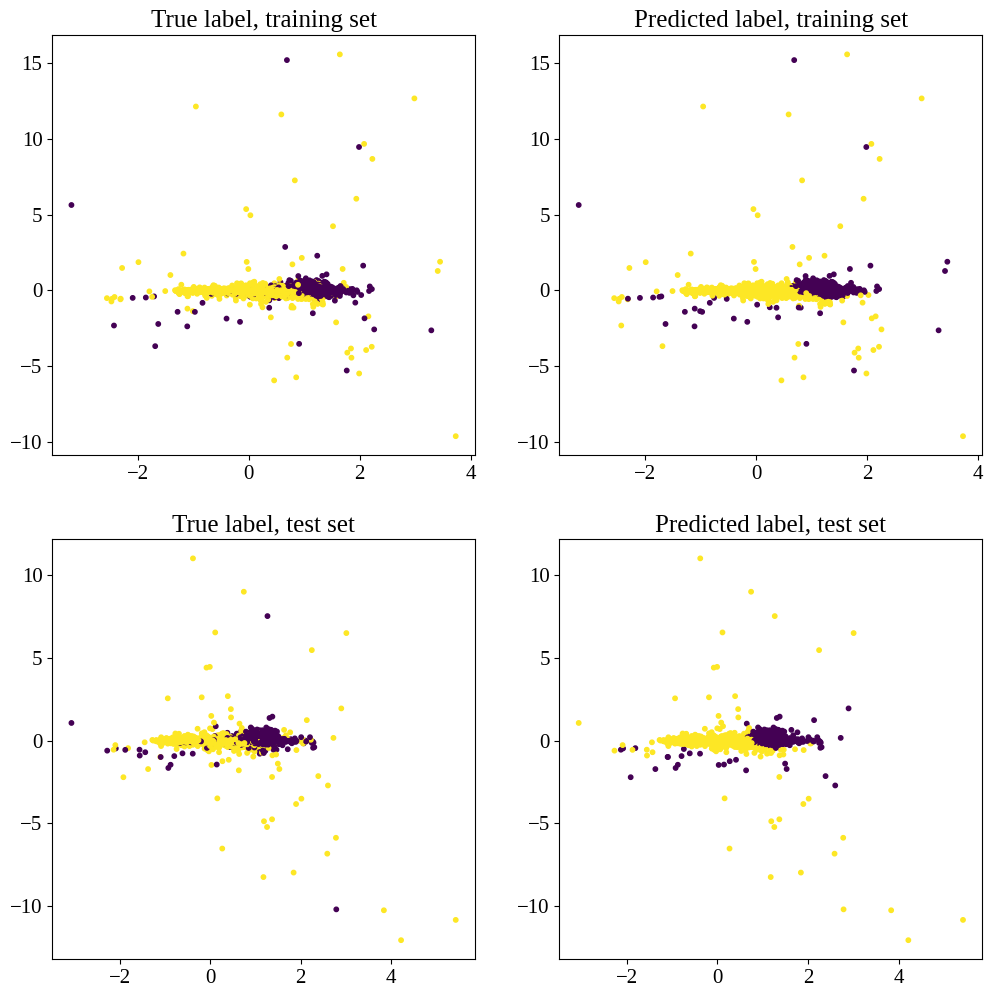

In [37]:
fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_train_r[:,0], X_train_r[:,1], c=y_train_r, s=s)
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_train_r[:,0], X_train_r[:,1], c=train_pred_gmm_r, s=s)
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_test_r[:,0], X_test_r[:,1], c=y_test_r, s=s)
plt.title('True label, test set')


ax=fig.add_subplot(224)
plt.scatter(X_test_r[:,0], X_test_r[:,1], c=test_pred_gmm_r, s=s)
plt.title('Predicted label, test set')

plt.show()

In [38]:
accuracy_train_gmm_r = accuracy_score(y_train_r, train_pred_gmm_r)
accuracy_test_gmm_r = accuracy_score(y_test_r, test_pred_gmm_r)

print('The accuracy of the training set is:', accuracy_train_gmm_r)
print('The accuracy of the test set is:', accuracy_test_gmm_r)

cm_train_gmm_r = confusion_matrix(y_train_r, train_pred_gmm_r)
cm_test_gmm_r = confusion_matrix(y_test_r, test_pred_gmm_r)

print('\n Confusion matrix of the training set: \n',  cm_train_gmm_r)
print('\n Confusion matrix of the test set: \n',  cm_test_gmm_r)

completeness_gmm_r, contamination_gmm_r = completeness_contamination(test_pred_gmm_r, y_test_r)

print("\ncompleteness", round(float(completeness_gmm_r),3))
print("contamination", round(float(contamination_gmm_r),3))

The accuracy of the training set is: 0.98144
The accuracy of the test set is: 0.9818

 Confusion matrix of the training set: 
 [[ 3238   325]
 [  139 21298]]

 Confusion matrix of the test set: 
 [[ 3276   295]
 [  160 21269]]

completeness 0.993
contamination 0.014


Let's try now to use **TSNE** to better separate the two groups. 

In [39]:
tsne = TSNE(n_components=2, learning_rate=200)
X_reduced_t = tsne.fit_transform(X)

In [40]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_reduced_t, label, test_size=0.5, random_state=1)

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=8)

ncom = np.linspace(1, 20, 20, dtype=int)
cverr_GMM = []
trainerr_GMM = []

for n in ncom:
    gmmb = GMMBayes(n, random_state=8)
    cverr, trainerr = errors_cv(X_train_r, y_train_r, gmmb)
    cverr_GMM.append(cverr)
    trainerr_GMM.append(trainerr)
    
ncom_best_t = ncom[cverr_GMM == min(cverr_GMM)][0]
print('best number of components:',ncom_best_t)

best number of components: 15


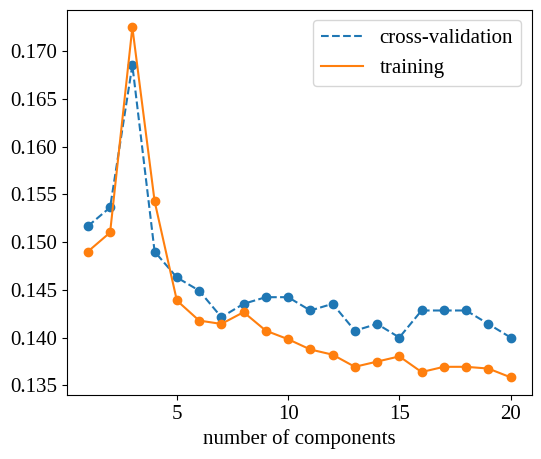

In [42]:
plt.scatter(ncom, cverr_GMM)
plt.scatter(ncom, trainerr_GMM)
plt.plot(ncom, cverr_GMM, '--', label='cross-validation')
plt.plot(ncom, trainerr_GMM, '-', label='training')
plt.legend()
plt.xlabel('number of components')
plt.show()

In [43]:
gmm_t = GMMBayes(ncom_best_t)
gmm_t.fit(X_train_t,y_train_t)

train_pred_gmm_t = gmm_t.predict(X_train_t)
test_pred_gmm_t = gmm_t.predict(X_test_t)

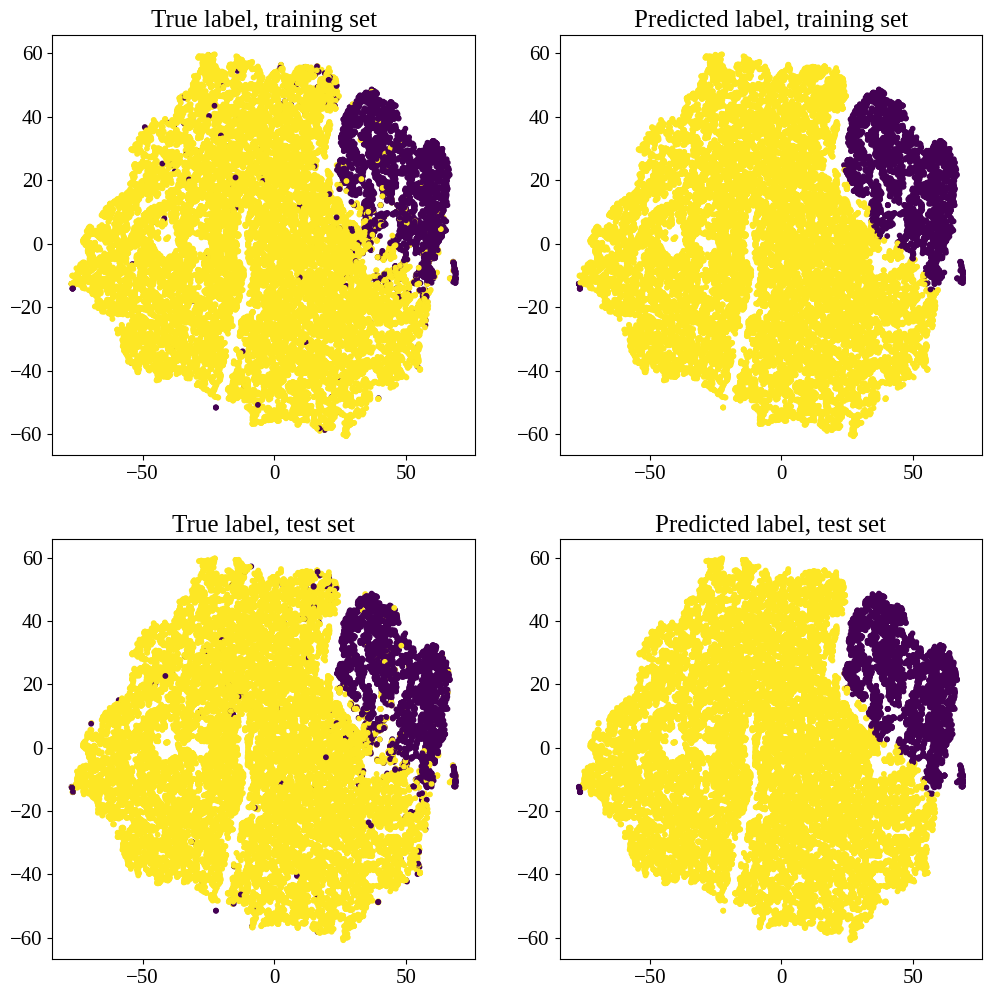

In [44]:
fig = plt.figure(figsize=(12,12))

ax=fig.add_subplot(221)
plt.scatter(X_train_t[:,0], X_train_t[:,1], c=y_train_t, s=s)
plt.title('True label, training set')

ax=fig.add_subplot(222)
plt.scatter(X_train_t[:,0], X_train_t[:,1], c=train_pred_gmm_t, s=s)
plt.title('Predicted label, training set')

ax=fig.add_subplot(223)
plt.scatter(X_test_t[:,0], X_test_t[:,1], c=y_test_t, s=s)
plt.title('True label, test set')


ax=fig.add_subplot(224)
plt.scatter(X_test_t[:,0], X_test_t[:,1], c=test_pred_gmm_t, s=s)
plt.title('Predicted label, test set')

plt.show()

In [45]:
accuracy_train_gmm_t = accuracy_score(y_train_t, train_pred_gmm_t)
accuracy_test_gmm_t = accuracy_score(y_test_t, test_pred_gmm_t)

print('The accuracy of the training set is:', accuracy_train_gmm_t)
print('The accuracy of the test set is:', accuracy_test_gmm_t)

cm_train_gmm_t = confusion_matrix(y_train_t, train_pred_gmm_t)
cm_test_gmm_t = confusion_matrix(y_test_t, test_pred_gmm_t)

print('\n Confusion matrix of the training set: \n',  cm_train_gmm_t)
print('\n Confusion matrix of the test set: \n',  cm_test_gmm_t)

completeness_gmm_t, contamination_gmm_t = completeness_contamination(test_pred_gmm_t, y_test_t)

print("\ncompleteness", round(float(completeness_gmm_t),3))
print("contamination", round(float(contamination_gmm_t),3))

The accuracy of the training set is: 0.98408
The accuracy of the test set is: 0.986

 Confusion matrix of the training set: 
 [[ 3308   255]
 [  143 21294]]

 Confusion matrix of the test set: 
 [[ 3378   193]
 [  157 21272]]

completeness 0.993
contamination 0.009


In [50]:
classifier=np.array(["Gaussian Naive Bayes", "GMMBayes", "KNN", "Random forest", "Boosting", 
                     "GMMBayes PCA", "GMMBayes TSNE"])
accuracy_train=np.array([accuracy_train_gnb, accuracy_train_gmm, accuracy_train_knc, accuracy_train_rf, 
                         accuracy_train_gb, accuracy_train_gmm_r, accuracy_train_gmm_t])
accuracy_test=np.array([accuracy_test_gnb, accuracy_test_gmm, accuracy_test_knc, accuracy_test_rf,
                         accuracy_test_gb, accuracy_test_gmm_r, accuracy_test_gmm_t])
completeness=np.array([completeness_gnb, completeness_gmm, completeness_knc, completeness_rf,
                         completeness_gb, completeness_gmm_r, completeness_gmm_t])
contamination=np.array([contamination_gnb, contamination_gmm, contamination_knc, contamination_rf,
                         contamination_gb, contamination_gmm_r, contamination_gmm_t])

results = np.array([classifier, accuracy_train, accuracy_test, completeness, contamination]).T

col_names=["classifier", "accuracy train", "accuracy test", "completeness", "contamination"]

print(tabulate(results, headers=col_names, tablefmt="fancy_grid"))

print("Best accuracy: ", classifier[np.argmax(accuracy_test)], "with an accuracy of ", np.max(accuracy_test))
print("Best completeness: ", classifier[np.argmax(completeness)], "with a completeness of ", np.max(completeness))
print("Lower contamination: ", classifier[np.argmin(contamination)], "with a contamination of ", 
      np.min(contamination))

╒══════════════════════╤══════════════════╤═════════════════╤════════════════╤═════════════════╕
│ classifier           │   accuracy train │   accuracy test │   completeness │   contamination │
╞══════════════════════╪══════════════════╪═════════════════╪════════════════╪═════════════════╡
│ Gaussian Naive Bayes │          0.97272 │         0.97388 │       0.9818   │      0.0123463  │
├──────────────────────┼──────────────────┼─────────────────┼────────────────┼─────────────────┤
│ GMMBayes             │          0.9854  │         0.98604 │       0.992487 │      0.00876212 │
├──────────────────────┼──────────────────┼─────────────────┼────────────────┼─────────────────┤
│ KNN                  │          0.98604 │         0.98664 │       0.993093 │      0.00866446 │
├──────────────────────┼──────────────────┼─────────────────┼────────────────┼─────────────────┤
│ Random forest        │          0.99912 │         0.98672 │       0.992813 │      0.00829721 │
├──────────────────────┼──────

We can observe that almost all the classifier provide similar results. The dimensionality reduction didn't improve the classification, but in general we obtained some very good results.